## ConvNeXt implementation
This is an implementation of the *ConvNeXt* architecture as proposed by *FAIR*.<br>
The original paper can be found here: https://github.com/facebookresearch/ConvNeXt<br>
The implementation below is inspired by: https://github.com/bamps53/convnext-tf

In [1]:
# imports
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import (Conv2D, Dense, DepthwiseConv2D,
                                     GlobalAveragePooling2D, Layer,
                                     LayerNormalization)

In [2]:
# loading the data
DIR_BASE = r'C:\Users\jch\Tensorflow\Project\Data\Samples'
DIR_TRAIN = r'C:\Users\jch\Tensorflow\Project\Data\Use\Train'
DIR_TEST = r'C:\Users\jch\Tensorflow\Project\Data\Use\Test'
DIR_VALID = r'C:\Users\jch\Tensorflow\Project\Data\Use\Valid'

#AUGMENTED_TRAIN = r'C:\Users\jch\Tensorflow\Project\Data\Use\Preprocessed\Augmented'

In [3]:
# show classes
os.listdir(DIR_TRAIN)

['CASPIAN TERN',
 'D-ARNAUDS BARBET',
 'DARK EYED JUNCO',
 'HOUSE FINCH',
 'OVENBIRD',
 'OYSTER CATCHER',
 'RED TAILED HAWK',
 'SWINHOES PHEASANT',
 'VIOLET GREEN SWALLOW',
 'WOOD DUCK']

In [4]:
# Class for mix-up implementation

class MixupImageDataGenerator():
# inspired by https://medium.com/swlh/how-to-do-mixup-training-from-image-files-in-keras-fe1e1c1e6da6

    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [6]:
# Set parameters
batch_size = 16
validation_split = 0.2
img_height = 224
img_width = 224
epochs = 10

# Optional additional image augmentation with ImageDataGenerator.
input_img = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=(0.95, 1.05),
    brightness_range=(1, 1.3),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split)

# Create training and validation generator.
train_generator = MixupImageDataGenerator(generator=input_img,
                                          directory=DIR_TRAIN,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height,
                                          subset='training')
validation_generator = input_img.flow_from_directory(DIR_TRAIN,
                                                       target_size=(
                                                           img_height, img_width),
                                                       class_mode="categorical",
                                                       batch_size=batch_size,
                                                       color_mode='rgb',
                                                       shuffle=True,
                                                       subset='validation')

print('training steps: ', train_generator.get_steps_per_epoch())
print('validation steps: ', validation_generator.samples // batch_size)

Found 800 images belonging to 10 classes.
Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
training steps:  50
validation steps:  12


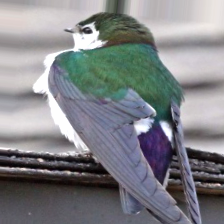

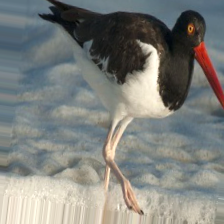

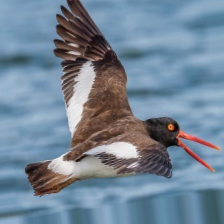

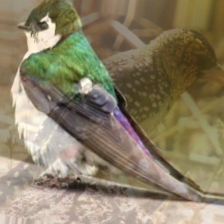

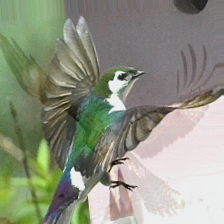

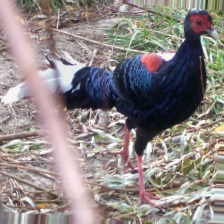

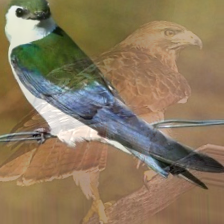

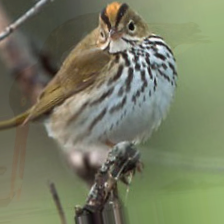

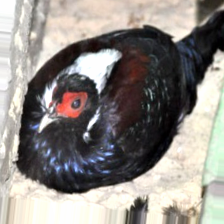

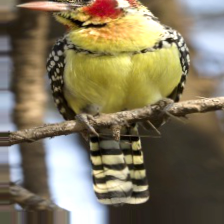

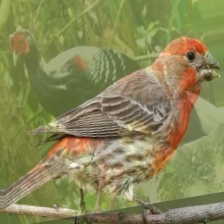

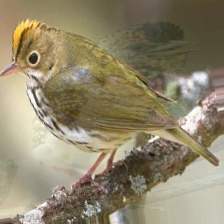

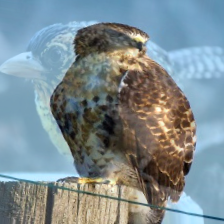

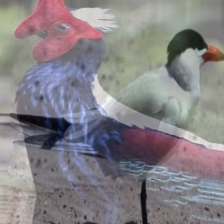

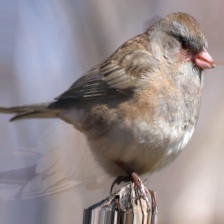

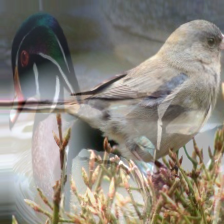

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.49256745e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.99999651e-01 0.00000000e+00]
 [1.73018792e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.98269812e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.53697998e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.46302002e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.03068783e-01 0.00000000e+00
  7.96931217e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.15688282e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 8.84311718e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

In [7]:
# Visualize batch of mixup images
sample_x, sample_y = next(train_generator)
for i in range(batch_size):
    display(image.array_to_img(sample_x[i]))
print(sample_y)

In [18]:
# drop path function / class for randomly dropping entire blocks ("stochastic depth")

def drop_path(inputs, drop_prob, is_training):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py who borrowed from https://github.com/rishigami/Swin-Transformer-TF/blob/main/swintransformer/model.py
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py who borrowed from https://github.com/rishigami/Swin-Transformer-TF/blob/main/swintransformer/model.py
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)

In [19]:
# Individual block class

class Block(Layer):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

    """ ConvNeXt Block (permutation from Pytorch to TF standards)
    DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    . N = number of images in the batch
    . H = height of the image
    . W = width of the image
    . C = number of channels of the image (3 for RGB)

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """

    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, prefix=''):
        super().__init__()
        self.dwconv = DepthwiseConv2D(
            kernel_size=7, padding='same')  # depthwise conv
        self.norm = LayerNormalization(epsilon=1e-6)
        
        # pointwise/1x1 convs, implemented with linear layers
        self.pwconv1 = Dense(4 * dim)
        self.act = tf.keras.activations.gelu
        self.pwconv2 = Dense(dim)
        self.drop_path = DropPath(drop_path)
        self.dim = dim
        self.layer_scale_init_value = layer_scale_init_value
        self.prefix = prefix

    def build(self, input_shape):
        self.gamma = tf.Variable(
            initial_value=self.layer_scale_init_value * tf.ones((self.dim)),
            trainable=True,
            name=f'{self.prefix}/gamma')
        self.built = True

    def call(self, x):
        input = x
        x = self.dwconv(x)
        # x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        # x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

In [20]:
class ConvNeXt(tf.keras.Model):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

    r""" ConvNeXt
        A Tensorflow keras impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        num_classes (int): Number of classes for classification head
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        include_top (bool): whether to add head or just use it as feature extractor. Default: True
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """

    def __init__(self, num_classes=10,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], include_top=True,
                 drop_path_rate=0., layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()
        self.include_top = include_top
        self.downsample_layers = []  # stem and 3 intermediate downsampling conv layers
        stem = tf.keras.Sequential([
            Conv2D(dims[0], kernel_size=4, strides=4, padding='same'),
            LayerNormalization(epsilon=1e-6)]
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = tf.keras.Sequential([
                LayerNormalization(epsilon=1e-6),
                Conv2D(dims[i+1], kernel_size=2, strides=2, padding='same')]
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = []  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x for x in np.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = tf.keras.Sequential(
                [Block(dim=dims[i], drop_path=dp_rates[cur + j],
                       layer_scale_init_value=layer_scale_init_value, prefix=f'block{i}') for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        if self.include_top:
            self.avg = GlobalAveragePooling2D()
            self.norm = LayerNormalization(epsilon=1e-6)  # final norm layer
            self.head = Dense(num_classes)
        else:
            self.avg = None
            self.norm = None
            self.head = None

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        if self.include_top:
            x = self.avg(x)
            x = self.norm(x)
            x = self.head(x)
        return x

In [21]:
# The models default variables seem to work well with the ImageNet 1000 dataset, but not with 10 classes (our case)

convnext = ConvNeXt(num_classes=10, depths=[3, 3, 9, 3], dims=[16, 32, 64, 128], include_top=True, drop_path_rate=0.3)

convnext.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
convnext.build(input_shape=(None, 224, 224, 3))
convnext.summary()

Model: "conv_ne_xt"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 56, 56, 16)        816       
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 32)        2112      
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 64)        8320      
                                                                 
 sequential_3 (Sequential)   (None, 7, 7, 128)         33024     
                                                                 
 sequential_4 (Sequential)   (None, 56, 56, 16)        8928      
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 32)        30144     
                                                                 
 sequential_6 (Sequential)   (None, 14, 14, 64)        3

In [22]:
convnext.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


KeyboardInterrupt: 

__________

Premade Model

In [29]:
# load pre-trained model and configure depth and dimensions
# copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

model_url = {
    "convnext_tiny_224": "https://github.com/bamps53/convnext-tf/releases/download/v0.1/convnext_tiny_1k_224_ema.h5"
}

model_configs = dict(
    convnext_tiny=dict(
        depths=[3, 3, 9, 3],
        dims=[96, 192, 384, 768]
    )
)

In [37]:
# function to build model (we confine the model to the most basic pre-trained model since we have less classes)
# copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

def create_model(model_name='convnext_tiny_1k', input_shape=(224, 224), num_classes=10, include_top=True, pretrained=True, use_tpu=False, **kwargs):
    cfg = model_configs['_'.join(model_name.split('_')[:2])]
    print(cfg)
    net = ConvNeXt(num_classes, cfg['depths'], cfg['dims'], include_top, **kwargs)
    net(tf.keras.Input(shape=(*input_shape, 3)))
    if pretrained is True:
        url = model_url
        pretrained_ckpt = tf.keras.utils.get_file(
            f'{model_name}.h5', url, untar=False)
        if use_tpu:
            load_locally = tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost')
            net.load_weights(
                pretrained_ckpt, options=load_locally, skip_mismatch=True)
        else:
            net.load_weights(pretrained_ckpt, skip_mismatch=True, by_name=True)

    return net

In [38]:
# intiliase model
x = tf.zeros((1, 224, 224, 3), dtype=tf.float32)

model = create_model()
out = model(x) # (1, 1000)

{'depths': [3, 3, 9, 3], 'dims': [96, 192, 384, 768]}


AttributeError: 'dict' object has no attribute 'timeout'